# Performance analysis

This notebook is dedicated to the analysis and comparison of performance characteristics between the Julia and Python implementations.

First, computation time is compared between the Julia and Python implementation.

Second, memory complexity is further analyzed for the Julia implementation of the universal life model.

Benchmarks were performed using this device:

In [1]:
versioninfo()

Julia Version 1.11.0-DEV.275
Commit fd695a7cd1c (2023-08-14 12:45 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 20 × 12th Gen Intel(R) Core(TM) i7-12700H
  WORD_SIZE: 64
  LLVM: libLLVM-15.0.7 (ORCJIT, alderlake)
  Threads: 1 on 20 virtual cores
Environment:
  JULIA_INFO_COLOR = green
  JULIA_NUM_THREADS = 
  JULIA_PKG_USE_CLI_GIT = true


In [2]:
using LifeSimulator, CairoMakie, BenchmarkTools, PythonCall, Accessors, Dates
CairoMakie.activate!(inline = true)
include("../read_model.jl")

read_savings_model

In [3]:
model = LifelibBasiclife()
sizes = [10, 100, 1_000, 10_000]
files = "basic_term/" .* ["model_point_table_10.csv", "model_point_table_100.csv", "model_point_table_1K.csv", "model_point_table_10K.csv"]
iterative_timings = Float64[]
memoized_timings = Float64[]
for file in files
  policies = policies_from_csv(file)

  push!(iterative_timings, minimum(@benchmark CashFlow(Simulation($model, $policies), $(ntimesteps(model)))).time * 1e-9)

  set_basic_term_policies!(policies)
  push!(memoized_timings, minimum(@benchmark begin
    empty_memoization_caches!()
    sum(LifeSimulator.pv_net_cf())
  end).time * 1e-9)
end

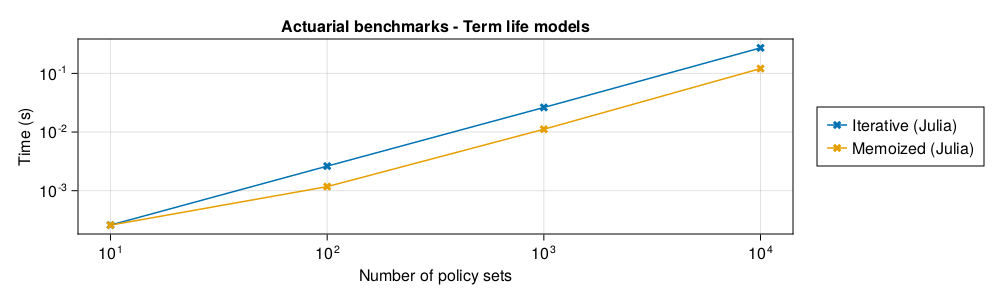

In [4]:
colors = Makie.wong_colors()
fig = Figure(; resolution = (1000, 300))
ax = Axis(fig[1, 1]; title = "Actuarial benchmarks - Term life models", xlabel = "Number of policy sets", ylabel = "Time (s)", xscale = log10, yscale = log10)
l1 = lines!(ax, sizes, iterative_timings; color = colors[1])
l2 = lines!(ax, sizes, memoized_timings; color = colors[2])
s1 = scatter!(ax, sizes, iterative_timings; color = colors[1], marker = :x)
s2 = scatter!(ax, sizes, memoized_timings; color = colors[2], marker = :x)
Legend(fig[1, 2], [[l1, s1], [l2, s2]], ["Iterative (Julia)", "Memoized (Julia)"])
fig

In [5]:
!@isdefined(proj) && (proj = read_savings_model())
proj.scen_size = 1
sizes = [9, 100, 1_000, 10_000, 100_000]
files = "savings/" .* ["model_point_table_9.csv", "model_point_table_100.csv", "model_point_table_1K.csv", "model_point_table_10K.csv", "model_point_table_100K.csv"]
julia_timings = Float64[]
python_timings = Float64[]
timeit = pyimport("timeit")
for (i, file) in enumerate(files)
  trials = Int(min(50, 3e5 ÷ sizes[i]))
  policies = policies_from_csv(file)

  # lifelib will always simulate until the largest policy term, so we make sure we have no policies beyond
  # a desired simulation end (e.g. 30 years) and at least one policy reaching such a term.
  # In this way, timesteps are consistent across evaluations with different numbers of policies.
  policies .= map(set -> @set(set.policy.issued_at = Month(0)), policies)
  policies .= map(set -> @set(set.policy.term = min(set.policy.term, Year(20))), policies)
  set = policies[1]; policies[1] = @set set.policy.term = Year(20)

  use_policies!(proj, policies)
  @assert ntimesteps(proj) == 241

  push!(julia_timings, minimum(@benchmark CashFlow(sim, n) setup = begin
    policies = policies_from_csv(proj)
    n = ntimesteps(proj)
    model = LifelibSavings(investment_rates = investment_rate(proj))
    sim = Simulation(model, policies)
  end).time * 1e-9)

  push!(python_timings, minimum(pyconvert(Array, timeit.repeat("proj.clear_cache = 1; proj.pv_net_cf().sum()"; globals = pydict(; proj), number = 1, repeat = trials))))
end

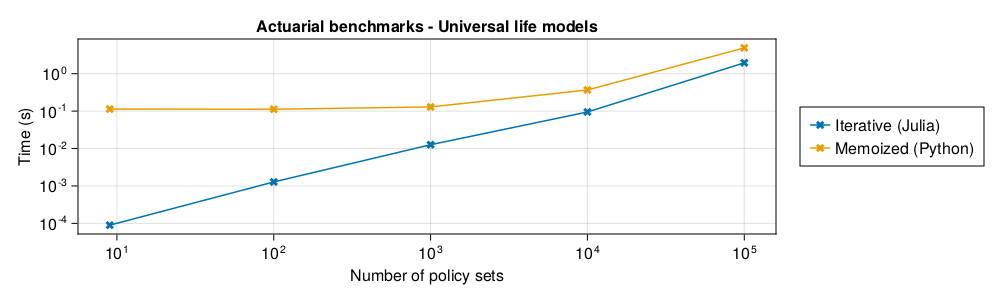

In [6]:
colors = Makie.wong_colors()
fig = Figure(; resolution = (1000, 300))
ax = Axis(fig[1, 1]; title = "Actuarial benchmarks - Universal life models", xlabel = "Number of policy sets", ylabel = "Time (s)", xscale = log10, yscale = log10)
l1 = lines!(ax, sizes, julia_timings; color = colors[1])
l2 = lines!(ax, sizes, python_timings; color = colors[2])
s1 = scatter!(ax, sizes, julia_timings; color = colors[1], marker = :x)
s2 = scatter!(ax, sizes, python_timings; color = colors[2], marker = :x)
Legend(fig[1, 2], [[l1, s1], [l2, s2]], ["Iterative (Julia)", "Memoized (Python)"])
fig

Using the universal life model, we can easily simulate millions of policies:

In [7]:
policies = rand(PolicySet, 10_000_000)
model = LifelibSavings()
@time CashFlow(Simulation(model, policies), 150)

125.682461 seconds (68.12 k allocations: 5.657 GiB, 0.41% gc time, 0.08% compilation time)


CashFlow(1.4142744915673675e17, 7.932934673287361e15, 5.552667666795282e16, 5.279775051424315e13, 7.071372457837255e15, 8.332923963297654e16, 3.3802973207433065e15, 3.0266845764077015e15)

## Memory complexity

We show here the memory complexity associated with the implementation of the universal life model. Results show that the memory complexity may be assumed independent of the number of timesteps, and that it scales linearly in the number of policy sets.

In [8]:
sizes = [9, 100, 1_000, 10_000, 100_000]
files = "savings/" .* ["model_point_table_9.csv", "model_point_table_100.csv", "model_point_table_1K.csv", "model_point_table_10K.csv", "model_point_table_100K.csv"]
ts = 50:50:150
allocations = zeros(length(files), length(ts))
model = LifelibSavings()
for (i, file) in enumerate(files)
  for (j, n) in enumerate(ts)
    policies = policies_from_csv(file)

    allocations[i, j] = (@benchmark CashFlow(Simulation($model, $policies), $n)).memory / 1e6
  end
end

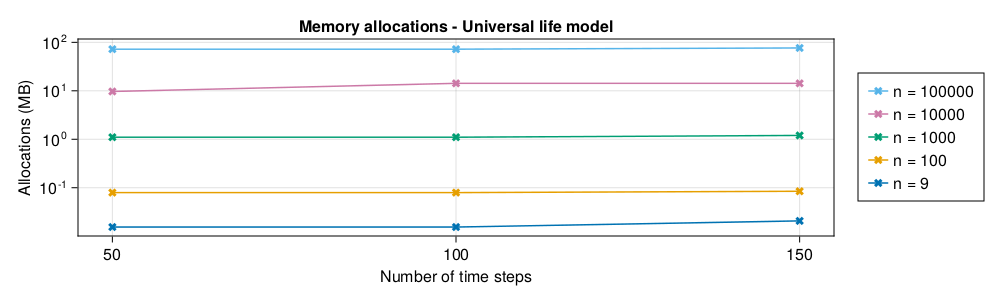

In [9]:
colors = Makie.wong_colors()
fig = Figure(; resolution = (1000, 300))
ax = Axis(fig[1, 1]; title = "Memory allocations - Universal life model", xlabel = "Number of time steps", ylabel = "Allocations (MB)", yscale = log10, xticks = ts)
ls = [lines!(ax, ts, allocations[i, :]; color = colors[i]) for i in eachindex(sizes)]
ss = [scatter!(ax, ts, allocations[i, :], color = colors[i]; marker = :x) for i in eachindex(sizes)]
Legend(fig[1, 2], reverse(collect(collect.(zip(ls, ss)))), "n = " .* reverse(string.(sizes)))
fig

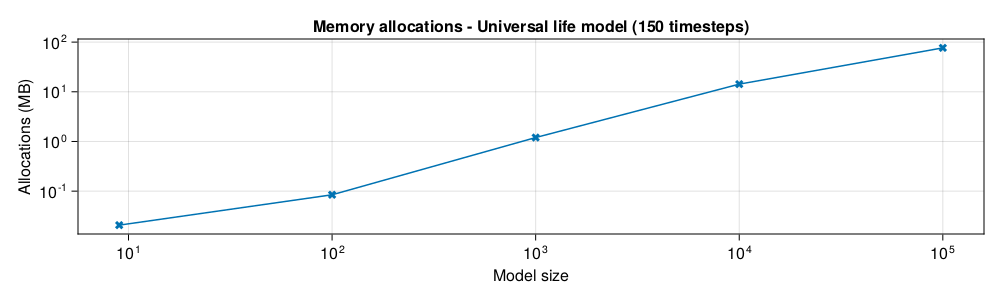

In [10]:

fig = Figure(; resolution = (1000, 300))
ax = Axis(fig[1, 1]; title = "Memory allocations - Universal life model ($(maximum(ts)) timesteps)", xlabel = "Model size", ylabel = "Allocations (MB)", xscale = log10, yscale = log10)
lines!(ax, sizes, allocations[:, end]; color = colors[1])
scatter!(ax, sizes, allocations[:, end]; color = colors[1], marker = :x)
fig